In [11]:
import pandas as pd 
import cv2, numpy as np
from scipy.stats import norm
from scipy.misc import imread, imsave
import re
import idx2numpy as idx
from copy import copy
import os
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# keras
np.random.seed(13)
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Dropout, Activation, Lambda, Layer # keras.layers.core 
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# logging
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [12]:
rootpath = "../EgyptianHieroglyphDataset/MyTrainTest"
original_dim = (75, 50) # without convolutional layers, use 75 * 50
batch_size = 32 * 2 # this has to be the same as the param value in the analysis code

In [140]:
datagen = ImageDataGenerator(
        rotation_range=45 # TODO too aggressive; Andrew suggests 10 or less
        , width_shift_range=0.05
        # , height_shift_range=0.05
        # , rescale=1./255 # rescale will happen when I import png at analysis
        , shear_range=0.5 # TODO too aggressive; Andrew suggests go way down
        , zoom_range=[1-0.05, 1+1]
        , horizontal_flip=False 
            # Egyptian heiroglyphs can actually be flipped depending on whether it's written from left to right
            # or right to left, but it looks like all my training/testing data are facing the same way, so I'll 
            # keep it simple
        , vertical_flip=False
        , fill_mode='nearest' # nearest is default
        , data_format='channels_first'
        )

# train

### first check my data distribution

In [4]:
tr_rootpath = os.path.join(rootpath, "train")
symbol_df = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
symbol_df = pd.DataFrame(sorted(symbol_df))
symbol_df.reset_index(inplace = True)
symbol_df.columns = ["symbol_num", "symbol"]
symbol_df.tail(1)

,symbol_num,symbol
170,170,Z7


In [4]:
tr_rootpath = os.path.join(rootpath, "train")
subdirs = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
tr_fnames = pd.DataFrame(columns = ["fname"])
for subdirpath in subdirs:
    subdir = os.path.join(tr_rootpath, subdirpath)
    files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
    for fpath in files:        
        pngfile = os.path.join(subdir, fpath)
        tr_fnames = pd.concat([tr_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
tr_fnames.reset_index(drop = True, inplace = True)

In [5]:
tr_fnames.tail(1)['fname'].tolist()[0]

'../EgyptianHieroglyphDataset/MyTrainTest/train/G25/410088_G25.png'

In [6]:
tr_fnames['label'] = tr_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [7]:
tr_fnames.tail(1)

,fname,label
3583,../EgyptianHieroglyphDataset/MyTrainTest/train...,G25


In [8]:
tr_counts = pd.DataFrame(tr_fnames["label"].value_counts())
tr_counts.reset_index(inplace = True)
tr_counts.columns = ["label", "ct"]
tr_counts.sort_values(by = "ct", inplace = True, ascending = False)
tr_counts.reset_index(drop = True, inplace = True)
tr_counts.head(2)

,label,ct
0,N35,403
1,M17,319


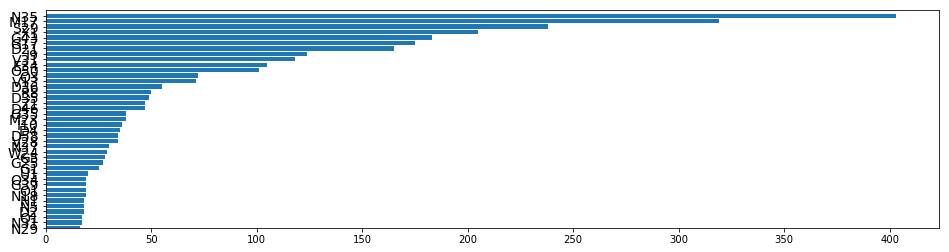

In [9]:
plt.figure(figsize = (16, 4))
n_rows = tr_counts.shape[0]
n_to_display = 40
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, tr_counts["ct"])
plt.yticks(xaxis, tr_counts["label"], fontsize = 14)
plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

### merge info into one table

In [10]:
tr_counts['new_img_ct'] = max(tr_counts["ct"]) - tr_counts["ct"]
tr_counts['new_img_rounded'] = tr_counts['new_img_ct'] + (batch_size - tr_counts['new_img_ct'] % batch_size)
tr_counts['new_img_per_orig_img'] = (tr_counts['new_img_rounded'] / tr_counts['ct']).map(np.ceil)

In [11]:
no_need_to_add_img = tr_counts['ct'] > 150
tr_counts.loc[no_need_to_add_img, 'new_img_per_orig_img'] = 0

In [12]:
variance_too_inflated = tr_counts['new_img_per_orig_img'] > 150
tr_counts.loc[variance_too_inflated, 'new_img_per_orig_img'] = 128

In [13]:
tr_counts.tail(2)

,label,ct,new_img_ct,new_img_rounded,new_img_per_orig_img
168,O29,1,402,416,128.0
169,V16,1,402,416,128.0


In [14]:
print(tr_fnames.shape)
tr_fnames = tr_fnames.merge(tr_counts, on = "label")
print(tr_fnames.shape)

(3584, 2)
(3584, 6)


In [15]:
tr_fnames.tail(2)

,fname,label,ct,new_img_ct,new_img_rounded,new_img_per_orig_img
3582,../EgyptianHieroglyphDataset/MyTrainTest/train...,G25,27,376,384,15.0
3583,../EgyptianHieroglyphDataset/MyTrainTest/train...,G25,27,376,384,15.0


### generate images

In [23]:
# range(tr_fnames.shape[0])
tr_fnames.loc[1000, :]

fname                   ../EgyptianHieroglyphDataset/MyTrainTest/train...
label                                                                  I9
ct                                                                    124
new_img_ct                                                            279
new_img_rounded                                                       288
new_img_per_orig_img                                                    3
Name: 1000, dtype: object

In [25]:
shape_dim = (1, 1) + (original_dim)
for row in range(tr_fnames.shape[0]):
    print(row)
    n_new = tr_fnames.loc[row, "new_img_per_orig_img"]
    if n_new > 0:
        pngfile = tr_fnames.loc[row, "fname"]
        label = tr_fnames.loc[row, "label"]
        newimg_dir = os.path.join(rootpath, "train", label)
        arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
        arrayfile = np.reshape(arrayfile, shape_dim) # note: no rescaling here!

        # the .flow() command below generates batches of randomly transformed images
        genflow = datagen.flow(x = arrayfile, y = None, batch_size=1, save_to_dir=None)
        i = 0
        for new_arrayfile in genflow:
            if i < n_new:
                new_arrayfile = np.reshape(new_arrayfile, original_dim)
                fname = "gen" + str(i) + "_" + pngfile.split("/")[-1]
                fpath = os.path.join(newimg_dir, fname)
                # print(fpath)
                imsave(fpath, new_arrayfile)
                i += 1
            else:
                break # otherwise the generator would loop indefinitely
print("done")

G25 3583 15 ../EgyptianHieroglyphDataset/MyTrainTest/train/G25/gen14_410088_G25.png


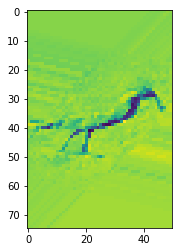

In [28]:
# spot check
print(label, row, i, fpath)
plt.figure()
plt.imshow(np.reshape(new_arrayfile, original_dim))
plt.show()

### double check resulting distribution

In [4]:
tr_rootpath = os.path.join(rootpath, "train")
symbol_df = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
symbol_df = pd.DataFrame(sorted(symbol_df))
symbol_df.reset_index(inplace = True)
symbol_df.columns = ["symbol_num", "symbol"]
symbol_df.tail(1)

,symbol_num,symbol
170,170,Z7


In [5]:
tr_rootpath = os.path.join(rootpath, "train")
subdirs = [x for x in os.listdir(tr_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
tr_fnames = pd.DataFrame(columns = ["fname"])
for subdirpath in subdirs:
    subdir = os.path.join(tr_rootpath, subdirpath)
    files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
    for fpath in files:        
        pngfile = os.path.join(subdir, fpath)
        tr_fnames = pd.concat([tr_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
tr_fnames.reset_index(drop = True, inplace = True)

In [6]:
tr_fnames['label'] = tr_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [7]:
tr_counts = pd.DataFrame(tr_fnames["label"].value_counts())
tr_counts.reset_index(inplace = True)
tr_counts.columns = ["label", "ct"]
tr_counts.sort_values(by = "ct", inplace = True, ascending = False)
tr_counts.reset_index(drop = True, inplace = True)
tr_counts.head(2)

,label,ct
0,O50,505
1,I9,496


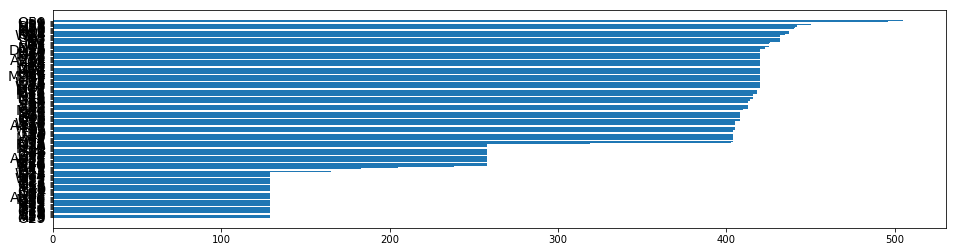

In [8]:
plt.figure(figsize = (16, 4))
n_rows = tr_counts.shape[0]
# n_to_display = 40
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, tr_counts["ct"])
plt.yticks(xaxis, tr_counts["label"], fontsize = 14)
# plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

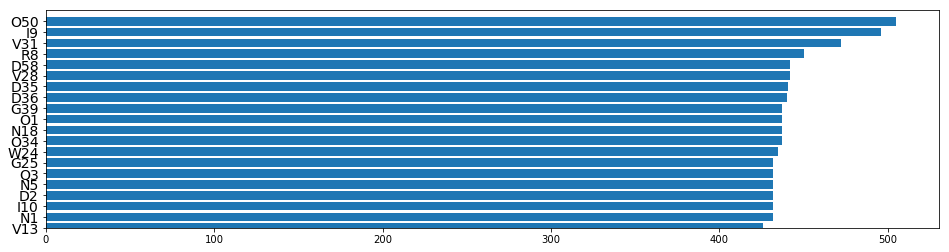

In [10]:
plt.figure(figsize = (16, 4))
n_rows = tr_counts.shape[0]
n_to_display = 20
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, tr_counts["ct"])
plt.yticks(xaxis, tr_counts["label"], fontsize = 14)
plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

### deal with M20 (it was only in test data for some reason; i added two training files via command line)

In [18]:
tr_rootpath = os.path.join(rootpath, "train")
tr_fnames = pd.DataFrame(columns = ["fname"])
subdirpath = 'M20'
subdir = os.path.join(tr_rootpath, subdirpath)
files = [x for x in os.listdir(subdir) if re.search(r"UNKNOWN|^\.", x) == None]
for fpath in files:        
    pngfile = os.path.join(subdir, fpath)
    tr_fnames = pd.concat([tr_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
tr_fnames.reset_index(drop = True, inplace = True)

In [19]:
tr_fnames['label'] = tr_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [20]:
tr_counts = pd.DataFrame(tr_fnames["label"].value_counts())
tr_counts.reset_index(inplace = True)
tr_counts.columns = ["label", "ct"]
tr_counts.sort_values(by = "ct", inplace = True, ascending = False)
tr_counts.reset_index(drop = True, inplace = True)

In [21]:
tr_counts['new_img_ct'] = 403 - tr_counts["ct"] # max(tr_counts["ct"]) - tr_counts["ct"]
tr_counts['new_img_rounded'] = tr_counts['new_img_ct'] + (batch_size - tr_counts['new_img_ct'] % batch_size)
tr_counts['new_img_per_orig_img'] = (tr_counts['new_img_rounded'] / tr_counts['ct']).map(np.ceil)

In [22]:
no_need_to_add_img = tr_counts['ct'] > 150
tr_counts.loc[no_need_to_add_img, 'new_img_per_orig_img'] = 0

In [23]:
variance_too_inflated = tr_counts['new_img_per_orig_img'] > 150
tr_counts.loc[variance_too_inflated, 'new_img_per_orig_img'] = 128

In [24]:
tr_fnames = tr_fnames.merge(tr_counts, on = "label")
tr_fnames

,fname,label,ct,new_img_ct,new_img_rounded,new_img_per_orig_img
0,../EgyptianHieroglyphDataset/MyTrainTest/train...,M20,2,401,416,128.0
1,../EgyptianHieroglyphDataset/MyTrainTest/train...,M20,2,401,416,128.0


In [26]:
shape_dim = (1, 1) + (original_dim)
for row in range(tr_fnames.shape[0]):
    print(row)
    n_new = tr_fnames.loc[row, "new_img_per_orig_img"]
    if n_new > 0:
        pngfile = tr_fnames.loc[row, "fname"]
        label = tr_fnames.loc[row, "label"]
        newimg_dir = os.path.join(rootpath, "train", label)
        arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
        arrayfile = np.reshape(arrayfile, shape_dim) # note: no rescaling here!

        # the .flow() command below generates batches of randomly transformed images
        genflow = datagen.flow(x = arrayfile, y = None, batch_size=1, save_to_dir=None)
        i = 0
        for new_arrayfile in genflow:
            if i < n_new:
                new_arrayfile = np.reshape(new_arrayfile, original_dim)
                fname = "gen" + str(i) + "_" + pngfile.split("/")[-1]
                fpath = os.path.join(newimg_dir, fname)
                # print(fpath)
                imsave(fpath, new_arrayfile)
                i += 1
            else:
                break # otherwise the generator would loop indefinitely
print("done")

0
1
done


M20 1 128 ../EgyptianHieroglyphDataset/MyTrainTest/train/M20/gen127_070015_M20.png


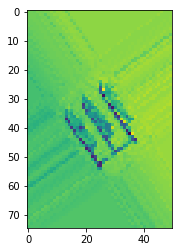

In [27]:
# spot check
print(label, row, i, fpath)
plt.figure()
plt.imshow(np.reshape(new_arrayfile, original_dim))
plt.show()

# test

### first check my data distribution

In [126]:
ts_rootpath = os.path.join(rootpath, "test")
files = [x for x in os.listdir(ts_rootpath) if re.search(r"UNKNOWN|^\.", x) == None]
ts_fnames = pd.DataFrame(columns = ["fname"])
for fpath in files:
    pngfile = os.path.join(ts_rootpath, fpath)
    ts_fnames = pd.concat([ts_fnames, pd.DataFrame({"fname": pngfile}, index = [0])])
ts_fnames.reset_index(drop = True, inplace = True)

In [127]:
ts_fnames.tail(1)['fname'].tolist()[0]

'../EgyptianHieroglyphDataset/MyTrainTest/test/070226_N35.png'

In [128]:
ts_fnames['label'] = ts_fnames['fname'].map(lambda x: re.sub(r".*\_(?P<label>.*)\.png", "\g<label>", x))

In [129]:
ts_fnames.tail(1)

,fname,label
448,../EgyptianHieroglyphDataset/MyTrainTest/test/...,N35


In [130]:
ts_counts = pd.DataFrame(ts_fnames["label"].value_counts())
ts_counts.reset_index(inplace = True)
ts_counts.columns = ["label", "ct"]
ts_counts.sort_values(by = "ct", inplace = True, ascending = False)
ts_counts.reset_index(drop = True, inplace = True)
ts_counts.head(2)

,label,ct
0,M17,46
1,N35,45


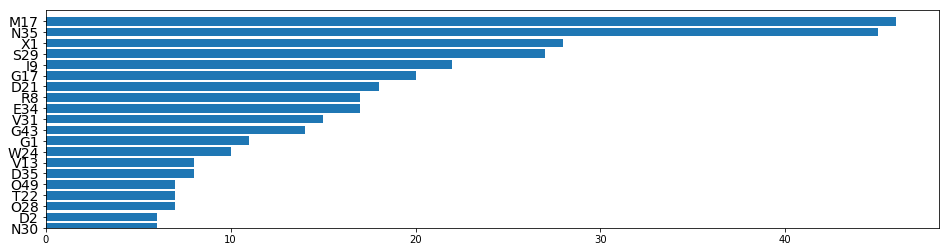

In [131]:
plt.figure(figsize = (16, 4))
n_rows = ts_counts.shape[0]
n_to_display = 20
xaxis = range(n_rows - 1, -1, -1)
plt.barh(xaxis, ts_counts["ct"])
plt.yticks(xaxis, ts_counts["label"], fontsize = 14)
plt.ylim([n_rows - n_to_display, n_rows])
plt.show()

### need to generate exactly 63 new images
Note: testing data distribution seems to follow freq distribution in real life (i.e. text from pyramid of Unas)

In [132]:
ts_counts.sort_values(by = "ct", inplace = True, ascending = True)
ts_counts.reset_index(drop = True, inplace = True)

In [133]:
ts_counts["new_img_per_label"] = 0
ts_counts.loc[:62, "new_img_per_label"] = 1 # pandas df includes the last index!
sum(ts_counts["new_img_per_label"])

63

In [134]:
print(ts_fnames.shape, ts_counts.shape)
ts_fnames = ts_fnames.merge(ts_counts, on = "label")
print(ts_fnames.shape)

(449, 2) (67, 3)
(449, 4)


In [135]:
ts_fnames["rand"] = np.random.random(ts_fnames.shape[0])
ts_fnames["rank"] = ts_fnames.groupby("label").rank()["rand"]
ts_fnames = ts_fnames.sort_values(["label", "rank"])
cond = (ts_fnames["new_img_per_label"] == 1) & (ts_fnames["rank"] == 1)
ts_fnames["new_img_per_orig_img"] = 0
ts_fnames.loc[cond, "new_img_per_orig_img"] = 1

In [145]:
ts_fnames.tail(1)

,fname,label,ct,new_img_per_label,rand,rank,new_img_per_orig_img
308,../EgyptianHieroglyphDataset/MyTrainTest/test/...,Z1,2,1,0.64918,2.0,0


In [139]:
# double check 
sum(ts_fnames["new_img_per_orig_img"])

63

### generate images

In [148]:
shape_dim = (1, 1) + (original_dim)
counter = 0
for row in range(ts_fnames.shape[0]):
    n_new = ts_fnames.loc[row, "new_img_per_orig_img"]
    if n_new > 0:
        pngfile = ts_fnames.loc[row, "fname"]
        label = ts_fnames.loc[row, "label"]
        arrayfile = imread(pngfile, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
        arrayfile = np.reshape(arrayfile, shape_dim) # note: no rescaling here!

        # the .flow() command below generates batches of randomly transformed images
        genflow = datagen.flow(x = arrayfile, y = None, batch_size=1, save_to_dir=None)
        i = 0
        for new_arrayfile in genflow:
            if i < n_new:
                new_arrayfile = np.reshape(new_arrayfile, original_dim)
                fname = "gen" + str(i) + "_" + pngfile.split("/")[-1]
                fpath = os.path.join(rootpath, "test", fname)
                # print(counter, fpath)
                imsave(fpath, new_arrayfile)
                counter += 1
                i += 1
            else:
                break # otherwise the generator would loop indefinitely
print("done")

done


S28 448 1 ../EgyptianHieroglyphDataset/MyTrainTest/test/gen0_070432_S28.png


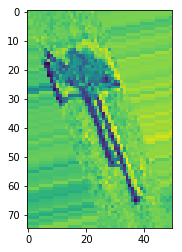

In [149]:
# spot check
print(label, row, i, fpath)
plt.figure()
plt.imshow(np.reshape(new_arrayfile, original_dim))
plt.show()